In [1]:
!nvidia-smi

Fri Sep 18 20:50:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    On   | 00000000:03:00.0  On |                  N/A |
| 34%   49C    P0    43W / 180W |   1294MiB /  8116MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
print(cv.cuda.getCudaEnabledDeviceCount())

### Read source image
src = cv.imread("lena.jpg", cv.IMREAD_GRAYSCALE)
w, h = src.shape[::-1]
print(src,w,h)

g_src = cv.cuda_GpuMat()
g_dst = cv.cuda_GpuMat()
g_src.upload(src)

1
[[131 137 131 ...  96  96  96]
 [132 135 133 ...  96  98  99]
 [134 132 135 ...  98  99 100]
 ...
 [110 109 114 ...  47  47  48]
 [107 109 111 ...  47  47  51]
 [101 107 109 ...  47  48  54]] 512 512


In [3]:
%%timeit
cpu_dst = cv.resize(src, (h*4, w*4), interpolation=cv.INTER_CUBIC)

638 µs ± 9.78 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [4]:
%%timeit
g_dst = cv.cuda.resize(g_src, (h*4, w*4), interpolation=cv.INTER_CUBIC)

919 µs ± 13.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [5]:
%%timeit
g_src.upload(src)
g_dst = cv.cuda.resize(g_src, (h*4, w*4), interpolation=cv.INTER_CUBIC)
gpu_dst = g_dst.download()

1.4 ms ± 63.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
ex_src = cv.resize(src, (h*4, w*4), interpolation=cv.INTER_CUBIC)
tmpl = ex_src[1000:1200, 1000:1200]
tw, th = tmpl.shape[::-1]

In [7]:
ex_src.shape

(2048, 2048)

In [8]:
%%timeit
result = cv.matchTemplate(ex_src, tmpl, cv.TM_CCOEFF_NORMED)

141 ms ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


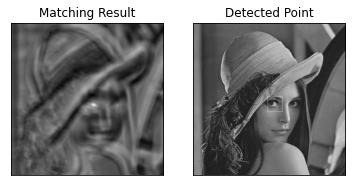

In [9]:
result = cv.matchTemplate(ex_src, tmpl, cv.TM_CCOEFF_NORMED)
min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)
top_left = max_loc
bottom_right = (top_left[0] + tw, top_left[1] + th)
cv.rectangle(ex_src,top_left, bottom_right, 255, 2)
plt.subplot(121),plt.imshow(result,cmap = 'gray')
plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(ex_src,cmap = 'gray')
plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
plt.show()

In [10]:
gsrc = cv.cuda_GpuMat()
gtmpl = cv.cuda_GpuMat()
gresult = cv.cuda_GpuMat()
gsrc.upload(ex_src)
gtmpl.upload(tmpl)
matcher = cv.cuda.createTemplateMatching(cv.CV_8UC1, cv.TM_CCOEFF_NORMED)

In [11]:
%%timeit
gresult = matcher.match(gsrc, gtmpl)

10.9 ms ± 386 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit
gsrc.upload(ex_src)
gtmpl.upload(tmpl)
matcher = cv.cuda.createTemplateMatching(cv.CV_8UC1, cv.TM_CCOEFF_NORMED)
gresult = matcher.match(gsrc, gtmpl)
resultg = gresult.download()

16.1 ms ± 495 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


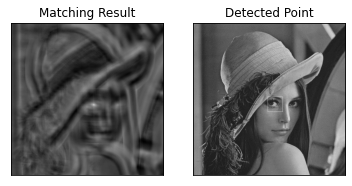

In [13]:
gresult = matcher.match(gsrc, gtmpl)
resultg = gresult.download()
min_valg, max_valg, min_locg, max_locg = cv.minMaxLoc(resultg)
top_leftg = max_locg
bottom_rightg = (top_leftg[0] + tw, top_leftg[1] + th)
cv.rectangle(src,top_leftg, bottom_rightg, 255, 2)
plt.subplot(121),plt.imshow(resultg,cmap = 'gray')
plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(ex_src,cmap = 'gray')
plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
plt.show()

In [15]:
print(max_loc,max_locg)

(1000, 1000) (1000, 1000)
